In [30]:
from torch.utils.data import Dataset, DataLoader
import cv2 
import numpy as np
import random
import os
from transformers import BertModel

In [31]:
def get_allpath(path):
    files = os.listdir(path)
    image_paths = []
    for f in files:
        images = os.listdir(path+"/"+f)
        for i in images:
            image_paths.append(path+"/"+f+"/"+i)
    return image_paths

In [32]:
train_image_paths = get_allpath("D:/cnn/seg_train/seg_train")
test_image_paths = get_allpath("D:/cnn/seg_test/seg_test")

In [33]:
random.shuffle(train_image_paths)
train_image_paths, valid_image_paths = train_image_paths[:int(
    .8*len(train_image_paths))], train_image_paths[int(.8*len(train_image_paths)):]

In [34]:
classes = os.listdir("D:/cnn/seg_train/seg_train")
class_to_ind = {}
for i in range(len(classes)):
    class_to_ind[classes[i]] = i

In [35]:
class_to_ind

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [36]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.Resize(width=227, height=227),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [37]:
class LandDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def 2(self, ind):
        image_p = self.image_paths[ind]
        image = cv2.imread(image_p)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = image_p.split("/")[-2]
        label = class_to_ind[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label


In [38]:
train_dataset = LandDataset(train_image_paths, transforms)
test_dataset = LandDataset(test_image_paths, transforms)
valid_dataset = LandDataset(valid_image_paths, transforms)

In [39]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)

The shape of tensor for 50th image in train dataset:  torch.Size([3, 227, 227])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


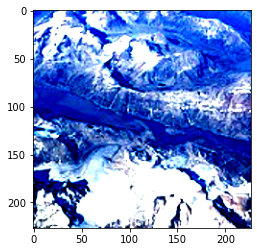

In [40]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[49][0].permute(1, 2, 0))


In [41]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


In [42]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=10)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
device.type

'cuda'

In [45]:
import torch.optim as optim
model = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.004)

In [46]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [47]:
if torch.cuda.is_available():
    model.cuda()
for epoch in range(66):
    loss_ep = 0
    for batch_idx, (data, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dataloader)}")

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(valid_dataloader):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 993.79 MiB already allocated; 0 bytes free; 1.03 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [41]:
model.eval()
with torch.no_grad():
    num_correct = 0
    num_samples = 0
    for batch_idx, (data,targets) in enumerate(test_dataloader):
        data = data.to(device=device)
        targets = targets.to(device=device) 
        ## Forward Pass
        scores = model(data)
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(
        f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
    )

Got 2471 / 3000 with accuracy 82.37


In [45]:
torch.save(model.state_dict(), "D:/model.pth")

In [83]:
def img_test(path) :
    img = cv2.imread("{}".format(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformers = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.Resize(width=227, height=227),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
    )
    transformed = transformers(image=img)
    img = transformed["image"]
    img = img.unsqueeze(0)
    img = img.to(device=device)
    scores = model(img)
    _,prediction = scores.max(1) 
    return prediction

In [85]:
print(img_test("E:/WallpaperDog-10882471.jpg"))

tensor([1], device='cuda:0')


In [ ]:
for epoch in range(66):
    loss_ep = 0
    for data, targets in train_dataloader:
        optimizer.zero_grad()
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dataloader)}")

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(valid_dataloader):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )